In [15]:
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.dataset import vision
from mindspore.dataset import transforms
from mindspore.dataset import MnistDataset
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子
seed = 1
np.random.seed(seed)
ms.set_seed(seed)

# 定义 LeNet5 模型
class LeNet5(nn.Cell):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, pad_mode='valid')
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, pad_mode='valid')
        self.fc1 = nn.Dense(4*4*50, 500)
        self.fc2 = nn.Dense(500, 10)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.max_pool2d(ops.relu(self.conv1(x)))
        x = self.max_pool2d(ops.relu(self.conv2(x)))
        x = self.flatten(x)
        x = ops.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 设置超参数
batch_size = 64
epochs = 10
lr = 0.1
weight_decay = 0.0

# 数据预处理
transform_image = [
    vision.Rescale(1.0 / 255.0, 0),
    vision.Normalize((0.1307,), (0.3081,)),
    vision.HWC2CHW()
]
transform_label = [transforms.TypeCast(ms.int32)]

# 加载数据集
dataset_path = "./MNIST"
train_dataset = MnistDataset(dataset_path, usage='train')
train_dataset = train_dataset.map(operations=transform_image, input_columns="image")
train_dataset = train_dataset.map(operations=transform_label, input_columns="label")
test_dataset = MnistDataset(dataset_path, usage='test')
test_dataset = test_dataset.map(operations=transform_image, input_columns="image")
test_dataset = test_dataset.map(operations=transform_label, input_columns="label")
train_loader = train_dataset.batch(batch_size, drop_remainder=True)
test_loader = test_dataset.batch(batch_size)

# 定义模型、损失函数和优化器
model = LeNet5()
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=lr, weight_decay=weight_decay)

# 定义训练步骤
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

# 定义测试函数
def test_accuracy(model, dataset):
    correct = 0
    total = 0
    model.set_train(False)
    for data in dataset.create_dict_iterator():
        images = ops.cast(data['image'], ms.float32)
        labels = ops.cast(data['label'], ms.int32)
        outputs = model(images)
        predicted = outputs.argmax(1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().asnumpy()
    accuracy = 100.0 * correct / total
    return accuracy

# 训练模型
for epoch in range(epochs):
    model.set_train()
    total_loss = 0
    for data in train_loader.create_dict_iterator():
        images = ops.cast(data['image'], ms.float32)
        labels = ops.cast(data['label'], ms.int32)
        loss = train_step(images, labels)
        total_loss += loss.asnumpy()
    
    accuracy = test_accuracy(model, test_loader)
    print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 保存模型
ms.save_checkpoint(model, 'models/LeNet5_mindspore1.ckpt')



Epoch 1, Loss: 512.9903, Accuracy: 85.29%
Epoch 2, Loss: 306.4120, Accuracy: 87.72%
Epoch 3, Loss: 259.9611, Accuracy: 88.77%
Epoch 4, Loss: 228.8808, Accuracy: 89.33%
Epoch 5, Loss: 204.9465, Accuracy: 89.63%
Epoch 6, Loss: 184.0518, Accuracy: 89.78%
Epoch 7, Loss: 164.8314, Accuracy: 89.84%
Epoch 8, Loss: 147.5928, Accuracy: 89.43%
Epoch 9, Loss: 130.2007, Accuracy: 89.09%
Epoch 10, Loss: 115.7408, Accuracy: 89.31%


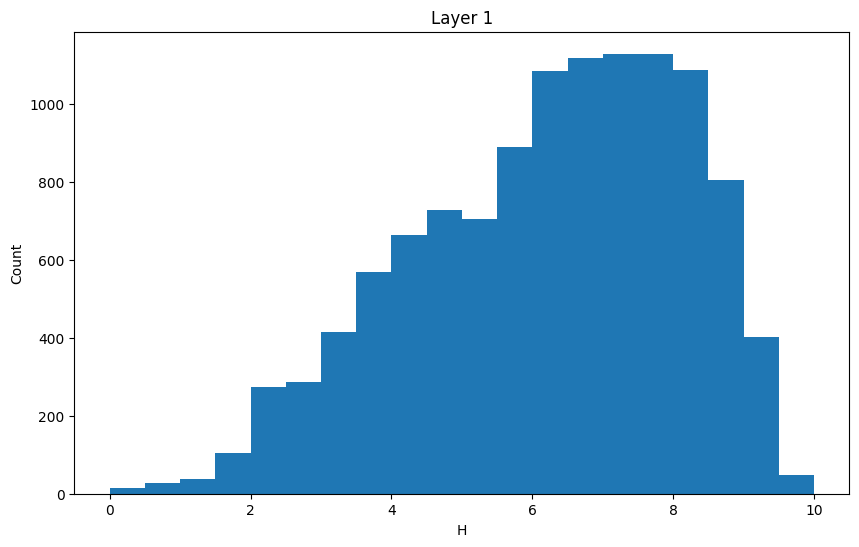

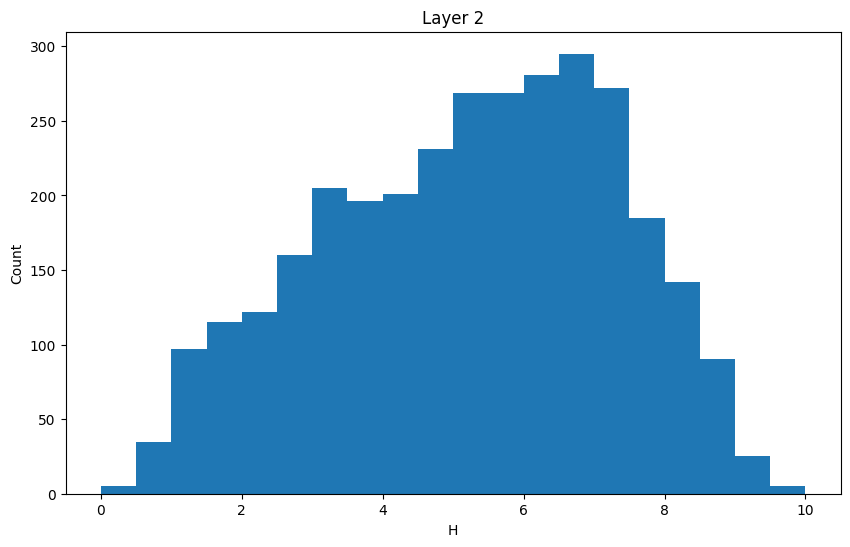

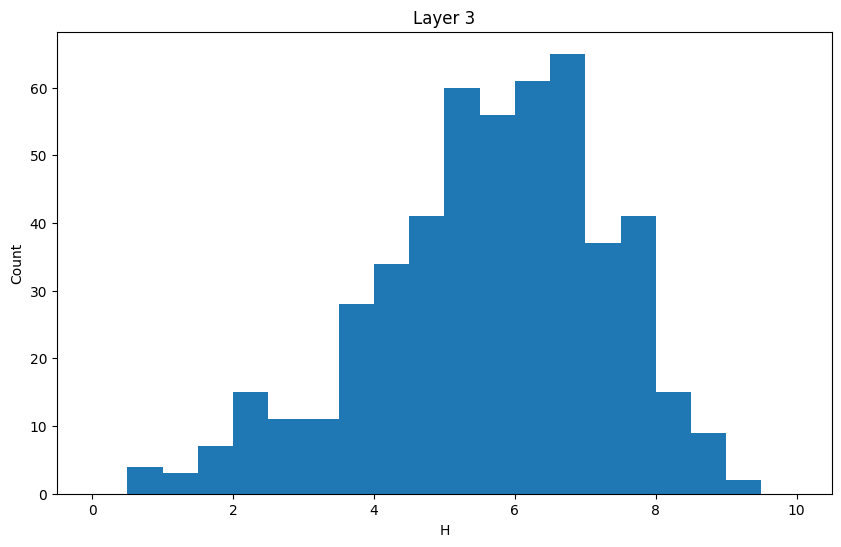

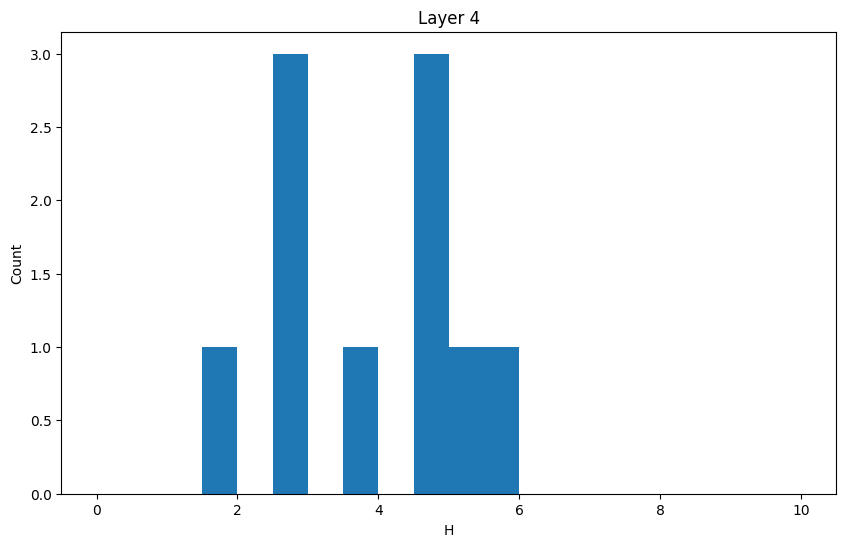

In [16]:
# 计算 PSP 熵
from src.PSPentropy import compute_PSPentropy
H, H_classwise = compute_PSPentropy(model, test_loader, order=1)

# 绘制直方图
for idx, layer_H in enumerate(H):
    plt.figure(figsize=(10, 6))
    plt.hist(layer_H.asnumpy().flatten(), bins=20, range=(0, 10))
    plt.title(f"Layer {idx + 1}")
    plt.xlabel("H")
    plt.ylabel("Count")
    plt.show()

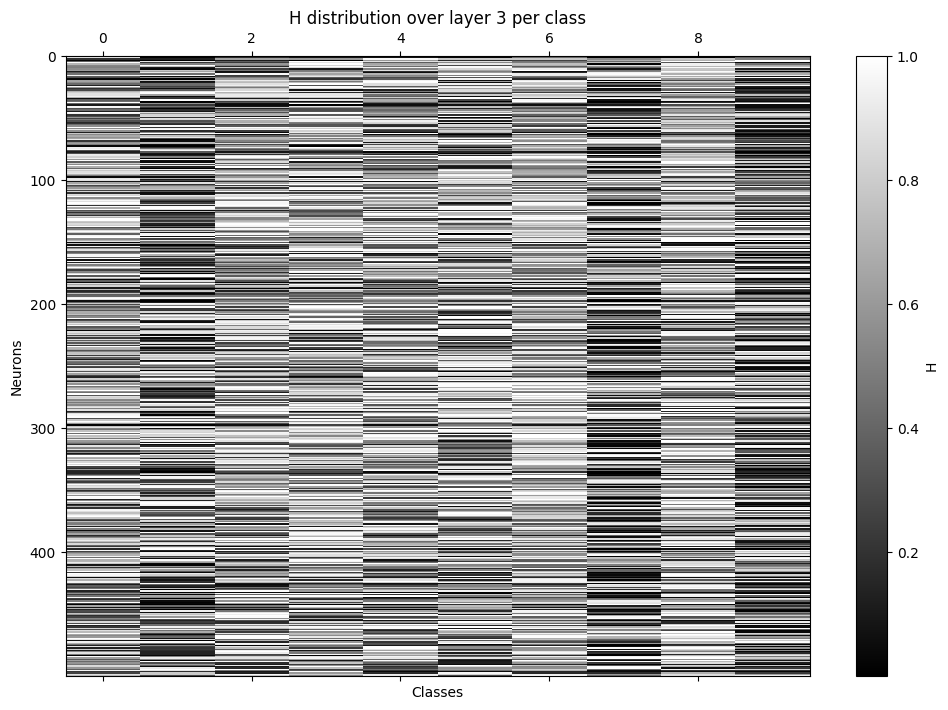

In [17]:
# 可视化第三层（全连接层）每个类别的熵分布
this_H = H_classwise[2].asnumpy().reshape(500, 10)
plt.figure(figsize=(12, 8))
plt.matshow(this_H, fignum=1, aspect='auto', cmap='gray')
plt.title("H distribution over layer 3 per class")
plt.xlabel("Classes")
plt.ylabel("Neurons")
plt.colorbar(label='H')
plt.show()